# Simulations

This section simulates business cycles with aggregate demand shocks. We also calculate optimal government spending in response to these shocks. The simulations are based on Section 5 in [Michaillat and Saez (2019](https://www.pascalmichaillat.org/6.html))

Before we start, we first set up the libraries and import the helper functions.

In [2]:
# %load setup.py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mtick
from itertools import product
%run helpers.ipynb

We then retrieve our calibrated parameter values from the previous sections and merge them for a full list of calibrated parameters.

In [3]:
params_suffstat = pd.read_csv('output/params_suffstat.csv')
params_sim = pd.read_csv('output/params_sim.csv')
params_full = pd.concat([params_suffstat, params_sim])
params_full = dict(params_full.values)
params_full

{'s': 0.035578947368421064,
 'u_bar': 0.05974999999999999,
 'x_bar': 0.557752047505985,
 'GC_bar': 0.19191729280673472,
 'M_bar': 0.5,
 'M_bar_l': 0.0,
 'M_bar_h': 2.0,
 'epsilon': 1.0,
 'epsilon_h': 1.5,
 'epsilon_l': 0.5,
 'eta': 0.6,
 'eta_l': 0.5,
 'eta_h': 0.7,
 'omega': 0.7071671173494025,
 'rho': 1.0808045754269548,
 'tau': 0.038731944011991065,
 'm_bar': 0.5100528390820994,
 'z0': 2.827830175507158,
 'z1': 2.2609135556386306,
 'GY_bar': 0.16101561237928394,
 'k': 1.0,
 'Y_bar': 0.94025,
 'gamma': 0.16101561237928394,
 'CY_bar': 0.8389843876207159,
 'r': 0.4562215934340784,
 'p0': 0.962712281801604}

## Simulations of Business Cycles
Fixing the public expenditure policy at $G/Y = 16.5\%$, we simulate business cycles using aggregate demand shocks. For each magnitude of aggregate demand, we find the equilibrium labor market tightness using grid search. 

The equation we rely on for finding equilibrium labor market tightness is the following: 

                $\frac{dU}{dc} - G = (1+\tau)\frac{p(G)}{\alpha}.$                       [![Generic badge](https://img.shields.io/badge/MS19-Eq%2013-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)

This condition is satisfied when aggregate supply equals aggregate demand. We want to find values of $x$ that equate the two sides of the equation with the function `find_eq`.

In [4]:
# Range of aggregate demand
ALPHA = np.arange(start=0.97, step=0.005, stop=1.03) 
# Grid to search for equilibrium tightness x
x0 = np.arange(start=0.001, step=0.001, stop=2) 
xad, Gad = np.empty(len(ALPHA)), np.empty(len(ALPHA))
G0 = params_full['GY_bar']*Y_func(x0, **params_full) # G such that G/Y=16.5%
for i, alpha in enumerate(ALPHA):
    eva = find_eq(G0, x0, alpha, **params_full)
    # Finding where AS = AD
    ind = np.argmin(eva)
    # Record equlibrium tightness and public expenditure
    xad[i] = x0[ind]
    Gad[i] = G0[ind]

We then compute all other equilibrium variables with $G/Y = 16.5\%$ under the aggregate demand shocks. 

In [5]:
ad = pd.DataFrame({'Y':Y_func(xad, **params_full),
                   'u':u_func(xad, **params_full), 
                   'M':M_func(G=Gad, x=xad, **params_full), 
                   'G/Y':Gad/Y_func(xad, **params_full)}, index=ALPHA)

Let's first look at equilibria under aggregate demand shocks and fixed public expenditure. We can see that aggregate demand shocks produce business cycles. 

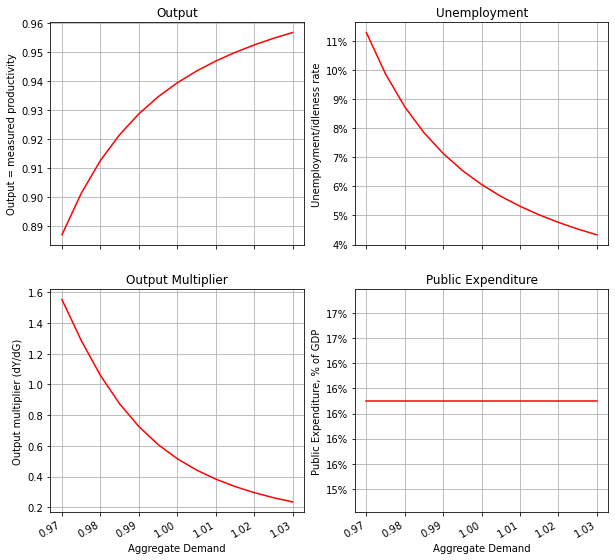

In [6]:
ad_axes = ad.plot(subplots=True, layout=(2, 2), title=['Output', 'Unemployment', 'Output Multiplier', 'Public Expenditure'], 
                  legend=False, figsize=(10, 10), grid=True, color='red')
ad_axes[0, 0].set(xlabel=r'$\alpha$', ylabel='Output = measured productivity')
ad_axes[0, 1].set(xlabel=r'$\alpha$', ylabel='Unemployment/idleness rate')
ad_axes[0, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ad_axes[1, 0].set(xlabel='Aggregate Demand', ylabel='Output multiplier (dY/dG)')
ad_axes[1, 1].set(xlabel='Aggregate Demand', ylabel='Public Expenditure, % of GDP')
ad_axes[1, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

## Optimal Stimulus

In this section, we calculate optimal stimulus over the business cycle. We compute optimal stimulus in two ways. First, we find exact optimal stimulus using a grid search. Second, we calculate optimal stimulus using the sufficient-statistics formula. We then compare the two as a validity check for the sufficient-statistics approach.

### Exact Optimal Stimulus

We first calculate the exact optimal stimulus. We make use of the property where optimal public expenditure satisfies the Samuelson rule plus a correction term:

                $1 = MRS_{gc} + \frac{\delta y}{\delta x}\frac{d x}{\delta g}.$          [![Generic badge](https://img.shields.io/badge/MS19-Eq%2018-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)  




In [7]:
xoptimal, Goptimal = np.empty(len(ALPHA)), np.empty(len(ALPHA))
# We now use grid search over a 2-d grid to find eq G and x
GY0 = np.arange(start=0.07, step=0.0005, stop=0.25) 
x1, GY1 = np.meshgrid(x0, GY0)
G1 = GY1*Y_func(x1, **params_full)
for i, alpha in enumerate(ALPHA):
    eva = find_eq(G=G1, x=x1, alpha=alpha, **params_full)
    # Finding all x's where AS = AD
    ind = np.argmin(eva, axis=1)
    x2 = x0[ind]
    G2 = GY0*Y_func(x2, **params_full)
    # Finding values of x and G for which the optimality equation is satisfied
    eva = optimal_func(G=G2, x=x2, **params_full)
    # Finding where AS = AD
    ind = np.argmin(eva)
    # Record equlibrium tightness and public expenditure
    xoptimal[i] = x2[ind]
    Goptimal[i] = G2[ind]

We now calculate other macroeconomic variables. 

In [8]:
exact_opt = pd.DataFrame({'Y':Y_func(x=xoptimal, **params_full),
                          'u':u_func(x=xoptimal, **params_full), 
                          'M':M_func(G=Goptimal, x=xoptimal, **params_full), 
                          'G/Y':Goptimal/Y_func(x=xoptimal, **params_full)}, index=ALPHA)

We can see how these variables compare to when $G/Y = 16.5\%$. Business cycle is much smoother under exact optimal public expenditure. We now see a flattened business cycle. 

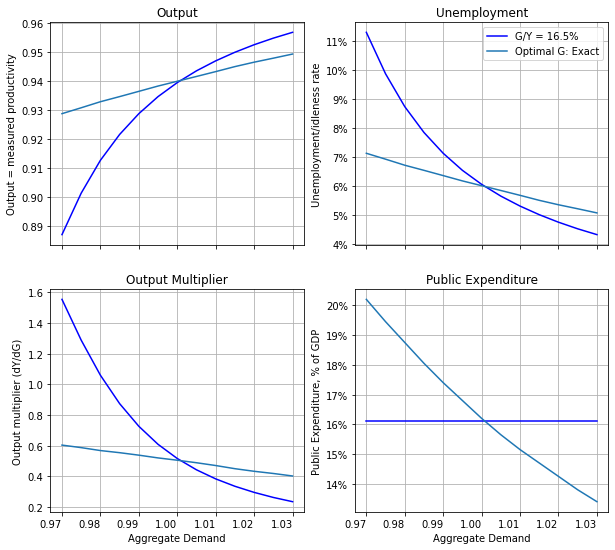

In [9]:
ad_axes = ad.plot(subplots=True, layout=(2, 2), title=['Output', 'Unemployment', 'Output Multiplier', 'Public Expenditure'], 
                  legend=False, figsize=(10, 10), grid=True, color='blue', label='G/Y = 15%')
exact_opt['Y'].plot(ax=ad_axes[0, 0], grid=True)
exact_opt['u'].plot(ax=ad_axes[0, 1], grid=True)
exact_opt['M'].plot(ax=ad_axes[1, 0], grid=True)
exact_opt['G/Y'].plot(ax=ad_axes[1, 1], grid=True)
ad_axes[0, 0].set(ylabel='Output = measured productivity')
ad_axes[0, 1].set(ylabel='Unemployment/idleness rate')
ad_axes[0, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ad_axes[1, 0].set(xlabel='Aggregate Demand', ylabel='Output multiplier (dY/dG)')
ad_axes[1, 1].set(xlabel='Aggregate Demand', ylabel='Public Expenditure, % of GDP')
ad_axes[0, 1].legend(['G/Y = 16.5%', 'Optimal G: Exact'])
ad_axes[1, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

### The Sufficient-Statistics Approach

Recall 

                $\frac{g/c - (g/c)^*}{(g/c)^*} \approx \frac{z_0 \epsilon m}{1 + z_1 z_0\epsilon m^2}\cdot \frac{u_0 - \bar{u}}{\bar{u}}.$          [![Generic badge](https://img.shields.io/badge/MS19-Eq%2023-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)  

We now compute optimal stimulus in response to aggregate demand shocks by using the formula above.

In [10]:
xsuffstat, Gsuffstat = np.empty(len(ALPHA)), np.empty(len(ALPHA))
for i, alpha in enumerate(ALPHA):
    u = u_func(xad[i], **params_full)
    # Calculate optimal stimulus with eq 23
    suffstat0 = suffstat_func(u0=u, m=m_func(which='dlnxdlng', G=Gad[i], x=xad[i], **params_full), **params_full)
    G0 = GY_func(GC=(1 + suffstat0)*params_full['GC_bar'])*Y_func(x0, **params_full)
    eva = find_eq(G0, x0, alpha, **params_full)
    # Finding where AS = AD
    ind = np.argmin(eva)
    # Record equlibrium tightness and public expenditure
    xsuffstat[i] = x0[ind]
    Gsuffstat[i] = G0[ind]

We compute other macroeconomics variables and compare them with when $G/Y$ is fixed at $16.5\%$. As expected, the business cycle is much smoother under stimulus. 

In [11]:
ss = pd.DataFrame({'Y':Y_func(x=xsuffstat, **params_full),
                   'u':u_func(x=xsuffstat, **params_full), 
                   'M':M_func(G=Gsuffstat, x=xsuffstat, **params_full), 
                   'G/Y':Gsuffstat/Y_func(x=xsuffstat, **params_full)}, index=ALPHA)

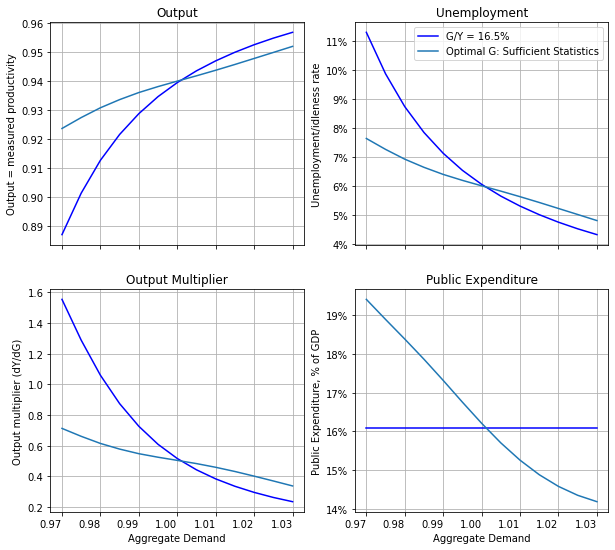

In [12]:
ad_axes = ad.plot(subplots=True, layout=(2, 2), title=['Output', 'Unemployment', 'Output Multiplier', 'Public Expenditure'], 
                legend=False, figsize=(10, 10), grid=True, color='blue', label='G/Y = 15%')
ss['Y'].plot(ax=ad_axes[0, 0], grid=True)
ss['u'].plot(ax=ad_axes[0, 1], grid=True)
ss['M'].plot(ax=ad_axes[1, 0], grid=True)
ss['G/Y'].plot(ax=ad_axes[1, 1], grid=True)
ad_axes[0, 0].set(ylabel='Output = measured productivity')
ad_axes[0, 1].set(ylabel='Unemployment/idleness rate')
ad_axes[0, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ad_axes[1, 0].set(xlabel='Aggregate Demand', ylabel='Output multiplier (dY/dG)')
ad_axes[1, 1].set(xlabel='Aggregate Demand', ylabel='Public Expenditure, % of GDP')
ad_axes[0, 1].legend(['G/Y = 16.5%', 'Optimal G: Sufficient Statistics'])
ad_axes[1, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

### Comparing the Two

We also compare the exact solution with the solution given by the sufficient-statistics formula. The graph below shows that the sufficient statistics approach serves as a good approximation of the exact approach. 

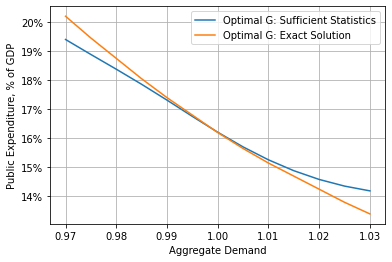

In [13]:
ss_ax = ss['G/Y'].plot(label='Optimal G: Sufficient Statistics', grid=True)
ss_ax.set(xlabel='Aggregate Demand', ylabel='Public Expenditure, % of GDP')
ss_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
exact_opt['G/Y'].plot(ax=ss_ax, grid=True, label='Optimal G: Exact Solution')
ss_ax.legend()